<h1 style='font-size: 25px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>Hypothesis Testing (One sample T-Test)</h1>

---

<h1 style='font-size: 18px;  font-weight: 600'>2.0: Import Required Libraries</h1>

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from scipy.stats import shapiro, levene, skew, kurtosis 
pd.set_option('display.max_columns', 9)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("...Libraries Loaded Successfully....")

...Libraries Loaded Successfully....


<h1 style='font-size: 18px; font-weight: 600'>3.0: Import and Preprocessing Dataset</h1>

In [4]:
filepath = "../Datasets/Soil Health Data.csv"
df = pd.read_csv(filepath)
display(df.head())

,Plot ID,Soil pH,Organic Matter (%),Nitrogen (%),...,Magnesium (cmol/kg),Sulfur (mg/kg),Zinc (mg/kg),Iron (mg/kg)
0,Plot 1,6.69,2.44,0.25,...,1.96,11.90,1.70,77.00
1,Plot 1,5.89,1.63,0.25,...,1.02,7.60,2.30,109.20
2,Plot 1,6.87,2.68,0.29,...,1.49,6.40,0.92,134.80
3,Plot 1,5.84,2.97,0.30,...,1.15,13.00,1.19,88.00
4,Plot 1,6.82,4.07,0.18,...,1.25,10.00,0.88,71.00


In [5]:
df = df[['Plot ID', 'Soil pH', 'Organic Matter (%)', 'Nitrogen (%)',
       'Phosphorus (mg/kg)', 'Potassium (cmol/kg)', 'Calcium (cmol/kg)',
       'Magnesium (cmol/kg)', 'Sulfur (mg/kg)',]]
df

,Plot ID,Soil pH,Organic Matter (%),Nitrogen (%),Phosphorus (mg/kg),Potassium (cmol/kg),Calcium (cmol/kg),Magnesium (cmol/kg),Sulfur (mg/kg)
0,Plot 1,6.69,2.44,0.25,16.80,0.82,11.18,1.96,11.90
1,Plot 1,5.89,1.63,0.25,23.40,1.11,6.01,1.02,7.60
2,Plot 1,6.87,2.68,0.29,20.10,1.14,11.17,1.49,6.40
3,Plot 1,5.84,2.97,0.30,17.60,0.84,6.69,1.15,13.00
4,Plot 1,6.82,4.07,0.18,13.10,0.81,4.02,1.25,10.00
...,...,...,...,...,...,...,...,...,...
145,Plot 5,6.93,3.33,0.30,18.10,1.13,13.79,2.01,13.30
146,Plot 5,6.38,3.25,0.26,27.00,0.86,11.18,1.56,11.50
147,Plot 5,6.26,3.79,0.26,15.80,0.76,7.65,1.22,11.90
148,Plot 5,6.26,2.18,0.26,27.00,0.81,16.18,1.79,11.90


<h1 style='font-size: 20px;  font-weight: 600'>4.0: Parametictic Test Assumption Validation</h1>

Before we advance to hypothesis testing — specifically the one-sample t-test — it's important to first check whether our variables meet the assumptions required for parametric tests, particularly **normality**. To do this, we’ll use the **Shapiro-Wilk test**, which helps us assess if the distribution of each variable is close to normal. This step ensures the validity of our statistical tests and guides us in choosing the right analysis methods.


In [6]:
def ShapirowilkTest(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) == 0:
        raise ValueError("No numerical columns found in the DataFrame.")
    
    results = []
    for col in numerical_cols:
        stat, p_value = shapiro(df[col])
        results.append({
            'Variable': col,
            'Statistic': stat,
            'P-Value': p_value,
            'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

shapiro_results = ShapirowilkTest(df)
display(shapiro_results)

,Variable,Statistic,P-Value,Normality
0,Soil pH,0.99,0.30,Normally Distributed
1,Organic Matter (%),0.99,0.29,Normally Distributed
2,Nitrogen (%),0.99,0.75,Normally Distributed
3,Phosphorus (mg/kg),0.99,0.47,Normally Distributed
4,Potassium (cmol/kg),0.99,0.36,Normally Distributed
5,Calcium (cmol/kg),0.99,0.88,Normally Distributed
6,Magnesium (cmol/kg),0.99,0.57,Normally Distributed
7,Sulfur (mg/kg),0.99,0.78,Normally Distributed


<h1 style='font-size: 18px;'>5.0: Hypothesis Testing (One-Sample t-test)</h1>

Now, let’s dive into the core of our analysis — hypothesis testing using a one-sample t-test — to assess whether the soil parameters we've measured truly align with the recommended standards for healthy crop growth. For each parameter (such as nitrogen, phosphorus, pH, etc.), we’ll formulate two hypotheses: the **null hypothesis (H₀)** assumes that the average value matches the ideal agronomic level, while the **alternative hypothesis (H₁)** suggests a significant difference, indicating a potential issue. In simple terms, we’re asking: *Does the average value we found reflect what’s best for crops?* To answer this, we’ll perform a t-test that compares each observed mean to its standard reference value. If a statistically significant difference is detected, it means the deviation is unlikely due to random chance, signaling that specific soil properties may need interventions like nutrient adjustments, pH correction, or organic matter enhancement to support optimal crop performance.

<h4 style='font-size: 15px;'>5.1: One-Sample t-Test</h4>

Now, we’ll perform the t-test for each parameter. This test will compare the average value we observed to the standard reference value. If we find a statistically significant difference, it means that the variation we’re seeing is unlikely to be due to random chance. This is our signal that the soil property in question may require management — maybe a boost in nutrients, pH adjustment, or organic matter improvement.

In [7]:
def one_sample_t_test(df, columns, population_means, alpha=0.05):
    results = []
    for col in columns:
        if col in df.columns and col in population_means:
            sample_data = df[col].dropna()
            pop_mean = population_means[col]
            
            t_stat, p_value = ttest_1samp(sample_data, pop_mean)
            mean_diff = sample_data.mean() - pop_mean
            interpretation = "Significant" if p_value < alpha else "Not Significant"
            
            results.append({
                "Parameter": col,
                "Sample Mean": sample_data.mean(),
                "Recommended Mean": pop_mean,
                "Mean Difference": mean_diff,
                "T-Statistic": t_stat,
                "P-Value": p_value,
                "Significance": interpretation
            })
    return pd.DataFrame(results)

# Recommended agronomic values
recommended_values = {
    "Soil pH": 6.5,
    "Organic Matter (%)": 3.0,  # in %
    "Nitrogen (%)": 0.2,        # in %
    "Phosphorus (mg/kg)": 15.0,     # in mg/kg
    "Potassium (cmol/kg)": 0.2,       # in cmol/kg
    "Calcium (cmol/kg)": 5.0,         # in cmol/kg
    "Magnesium (cmol/kg)": 1.5,       # in cmol/kg
    "Sulfur (mg/kg)": 10.0,         # in mg/kg
    "Zinc (mg/kg)": 1.0,            # in mg/kg
    #"Iron (mg/kg)": 5.0             # in mg/kg
}

results_df = one_sample_t_test(df, df.columns, recommended_values)
results_df

,Parameter,Sample Mean,Recommended Mean,Mean Difference,T-Statistic,P-Value,Significance
0,Soil pH,6.47,6.50,-0.03,-0.70,0.48,Not Significant
1,Organic Matter (%),2.75,3.00,-0.25,-5.27,0.00,Significant
2,Nitrogen (%),0.25,0.20,0.05,11.78,0.00,Significant
3,Phosphorus (mg/kg),18.92,15.00,3.92,10.42,0.00,Significant
4,Potassium (cmol/kg),0.82,0.20,0.62,37.11,0.00,Significant
5,Calcium (cmol/kg),10.37,5.00,5.37,20.79,0.00,Significant
6,Magnesium (cmol/kg),1.54,1.50,0.04,1.54,0.13,Not Significant
7,Sulfur (mg/kg),12.00,10.00,2.00,8.15,0.00,Significant


<h4 style='font-size: 15px;'>5.2: Results Table</h4>

The table below presents the results of the one-sample t-tests, showing the sample means, hypothesized agronomic values, test statistics, p-values, and conclusions—clearly identifying which soil parameters significantly differ from recommended benchmarks.

In [8]:
display(results_df)

,Parameter,Sample Mean,Recommended Mean,Mean Difference,T-Statistic,P-Value,Significance
0,Soil pH,6.47,6.50,-0.03,-0.70,0.48,Not Significant
1,Organic Matter (%),2.75,3.00,-0.25,-5.27,0.00,Significant
2,Nitrogen (%),0.25,0.20,0.05,11.78,0.00,Significant
3,Phosphorus (mg/kg),18.92,15.00,3.92,10.42,0.00,Significant
4,Potassium (cmol/kg),0.82,0.20,0.62,37.11,0.00,Significant
5,Calcium (cmol/kg),10.37,5.00,5.37,20.79,0.00,Significant
6,Magnesium (cmol/kg),1.54,1.50,0.04,1.54,0.13,Not Significant
7,Sulfur (mg/kg),12.00,10.00,2.00,8.15,0.00,Significant


<h1 style='font-size: 18px;'>6.0: Visual Explorations</h1>

To gain a more intuitive understanding of how each soil parameter compares to its recommended value, we visualize the results using bar plots. These plots make it easier to identify which parameters deviate noticeably and help highlight statistically significant differences at a glance.


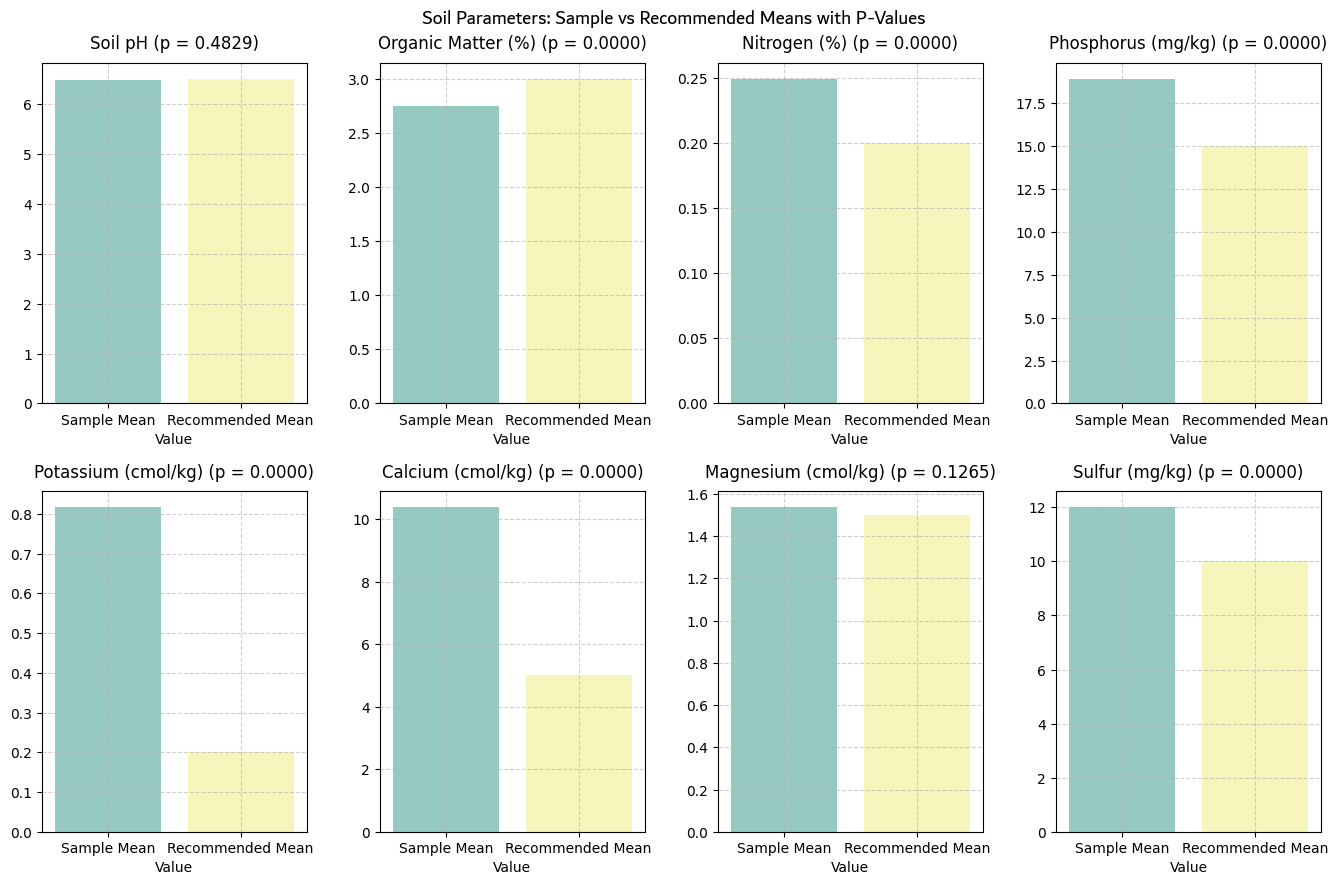

In [9]:
def reshape_results_for_facet_plot(results_df):
    melted = pd.melt(
        results_df,
        id_vars=["Parameter", "P-Value", "Significance"],
        value_vars=["Sample Mean", "Recommended Mean"],
        var_name="Type",
        value_name="Value"
    )
    return melted

def plot_variable_distributions_with_pvalues(data, group_col="Parameter", p_col="P-Value"):
    Variables = data[group_col].unique()
    num_variables = len(Variables)
    
    cols = 4
    rows = math.ceil(num_variables / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(3.4*cols, 4.5*rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.size': 11})
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, variable in enumerate(Variables):
        subset = data[data[group_col] == variable]
        
        # Extract unique p-value for this parameter
        p_val = subset[p_col].dropna().unique()
        p_val_str = f" (p = {p_val[0]:.4f})" if len(p_val) > 0 else ""

        sns.barplot(
            data=subset,
            y="Value", x="Type",
            ax=axes[idx],
            hue = 'Type',
            palette="Set3",
            linewidth=0.9,
            alpha=1
        )

        axes[idx].set_title(f"{variable}{p_val_str}", fontsize=12, pad=10)
        axes[idx].set_xlabel("Value")
        axes[idx].set_ylabel("")
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].legend_.remove() if axes[idx].get_legend() else None

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle("Soil Parameters: Sample vs Recommended Means with P-Values", fontsize=14)
    plt.show()

# Example usage:
data = reshape_results_for_facet_plot(results_df)
plot_variable_distributions_with_pvalues(data)


---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions.

---

<h5 style='font-size: 65px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>THE END</h5>